In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_49.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_67_1.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_90.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_77.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_20_1.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_66.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_54.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_106_1.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_42.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_81.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_72.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_107.wav
/kaggle/input/shl-in

In [4]:
import os, gc, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import librosa, librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import lightgbm as lgb

warnings.filterwarnings('ignore')
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [5]:
BASE_DIR = Path("/kaggle/input/shl-intern-hiring-assessment-2025/dataset")
AUDIO_DIR_TRAIN = BASE_DIR / "audios" / "train"
AUDIO_DIR_TEST = BASE_DIR / "audios" / "test"
CSV_DIR = BASE_DIR / "csvs"

train = pd.read_csv(CSV_DIR / "train.csv")
test = pd.read_csv(CSV_DIR / "test.csv")

# Fix filenames if needed (.wav extension)
if not train["filename"].iloc[0].endswith(".wav"):
    train["path"] = train["filename"].apply(lambda x: str(AUDIO_DIR_TRAIN / f"{x}.wav"))
else:
    train["path"] = train["filename"].apply(lambda x: str(AUDIO_DIR_TRAIN / x))

if not test["filename"].iloc[0].endswith(".wav"):
    test["path"] = test["filename"].apply(lambda x: str(AUDIO_DIR_TEST / f"{x}.wav"))
else:
    test["path"] = test["filename"].apply(lambda x: str(AUDIO_DIR_TEST / x))

# Verify that files exist
missing_train = [p for p in train["path"] if not Path(p).exists()]
missing_test = [p for p in test["path"] if not Path(p).exists()]
print(f"Train files missing: {len(missing_train)} | Test files missing: {len(missing_test)}")
print(" Data loaded successfully!")

print(train.head())

Train files missing: 0 | Test files missing: 0
 Data loaded successfully!
    filename  label                                               path
0  audio_173    3.0  /kaggle/input/shl-intern-hiring-assessment-202...
1  audio_138    3.0  /kaggle/input/shl-intern-hiring-assessment-202...
2  audio_127    2.0  /kaggle/input/shl-intern-hiring-assessment-202...
3   audio_95    2.0  /kaggle/input/shl-intern-hiring-assessment-202...
4   audio_73    3.5  /kaggle/input/shl-intern-hiring-assessment-202...


In [6]:
def extract_features(path, sr=22050, n_mfcc=13):
    try:
        y, sr = librosa.load(path, sr=sr)
        y, _ = librosa.effects.trim(y)
        if len(y) < 0.1 * sr:
            y = np.pad(y, (0, int(sr * 0.5)), mode='constant')
    except Exception as e:
        print(f"⚠️ Error loading {path}: {e}")
        return np.zeros(13*2 + 12*2 + 7*2 + 4)

    # MFCC features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean, mfcc_std = np.mean(mfcc, axis=1), np.std(mfcc, axis=1)

    # Chroma
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean, chroma_std = np.mean(chroma, axis=1), np.std(chroma, axis=1)

    # Spectral contrast
    spec_ct = librosa.feature.spectral_contrast(y=y, sr=sr)
    spec_ct_mean, spec_ct_std = np.mean(spec_ct, axis=1), np.std(spec_ct, axis=1)

    # ZCR & RMS
    zcr = librosa.feature.zero_crossing_rate(y)[0]
    rms = librosa.feature.rms(y=y)[0]
    zcr_mean, zcr_std = np.mean(zcr), np.std(zcr)
    rms_mean, rms_std = np.mean(rms), np.std(rms)

    feats = np.concatenate([
        mfcc_mean, mfcc_std,
        chroma_mean, chroma_std,
        spec_ct_mean, spec_ct_std,
        [zcr_mean, zcr_std, rms_mean, rms_std]
    ])
    return feats


In [7]:
def build_feature_df(df, verbose=True):
    rows = []
    for i, row in df.iterrows():
        feats = extract_features(row["path"])
        rows.append(feats)
        if verbose and (i+1) % 50 == 0:
            print(f"Processed {i+1}/{len(df)} files...")
    arr = np.vstack(rows)

    # Create column names
    n_mfcc = 13
    cols = [f"mfcc_mean_{i+1}" for i in range(n_mfcc)] + [f"mfcc_std_{i+1}" for i in range(n_mfcc)]
    cols += [f"chroma_mean_{i+1}" for i in range(12)] + [f"chroma_std_{i+1}" for i in range(12)]
    cols += [f"specct_mean_{i+1}" for i in range(7)] + [f"specct_std_{i+1}" for i in range(7)]
    cols += ["zcr_mean", "zcr_std", "rms_mean", "rms_std"]

    feat_df = pd.DataFrame(arr, columns=cols)
    feat_df["filename"] = df["filename"].values
    return feat_df


print("🔹 Extracting training features...")
train_feats = build_feature_df(train)
print("🔹 Extracting testing features...")
test_feats = build_feature_df(test)


🔹 Extracting training features...
Processed 50/409 files...
Processed 100/409 files...
Processed 150/409 files...
Processed 200/409 files...
Processed 250/409 files...
Processed 300/409 files...
Processed 350/409 files...
Processed 400/409 files...
🔹 Extracting testing features...
Processed 50/197 files...
Processed 100/197 files...
Processed 150/197 files...


In [8]:
# 🔹 MERGE FEATURES + LABELS
train_merged = train.merge(train_feats, on="filename", how="left")
test_merged = test.merge(test_feats, on="filename", how="left")

feature_cols = [c for c in train_merged.columns if c not in ["filename", "label", "path"]]
X = train_merged[feature_cols].values
y = train_merged["label"].values
X_test = test_merged[feature_cols].values

# Impute + Scale
imp = SimpleImputer(strategy="mean")
X = imp.fit_transform(X)
X_test = imp.transform(X_test)

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

In [9]:
import gc
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
oof = np.zeros(len(X))
models = []
feature_importance_df = pd.DataFrame()

params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "seed": RANDOM_SEED,
    "learning_rate": 0.05,
    "num_leaves": 31,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5
}

for fold, (tr_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"\n========== Fold {fold+1} ==========")
    X_tr, X_val = X[tr_idx], X[val_idx]
    y_tr, y_val = y[tr_idx], y[val_idx]

    dtrain = lgb.Dataset(X_tr, label=y_tr)
    dval = lgb.Dataset(X_val, label=y_val)

    # ✅ New LightGBM training syntax (v4+ compatible)
    model = lgb.train(
        params,
        dtrain,
        num_boost_round=2000,
        valid_sets=[dtrain, dval],
        valid_names=["train", "valid"],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=100)
        ],
    )

    val_preds = model.predict(X_val, num_iteration=model.best_iteration)
    oof[val_idx] = val_preds
    models.append(model)

    # Feature importances
    imp_df = pd.DataFrame({
        "feature": feature_cols,
        "importance": model.feature_importance(importance_type="gain")
    })
    imp_df["fold"] = fold + 1
    feature_importance_df = pd.concat([feature_importance_df, imp_df], axis=0)
    gc.collect()

train_rmse = mean_squared_error(y, oof, squared=False)
print("\n✅ Final OOF RMSE on training data:", train_rmse)



========== Fold 1 ==========
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's rmse: 0.486232	valid's rmse: 0.667651

========== Fold 2 ==========
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 0.328757	valid's rmse: 0.647054
Early stopping, best iteration is:
[113]	train's rmse: 0.303273	valid's rmse: 0.646236

========== Fold 3 ==========
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 0.315692	valid's rmse: 0.779403
Early stopping, best iteration is:
[80]	train's rmse: 0.359404	valid's rmse: 0.770888

========== Fold 4 ==========
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 0.318911	valid's rmse: 0.623372
Early stopping, best iteration is:
[74]	train's rmse: 0.388706	valid's rmse: 0.617665

========== Fold 5 ==========
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train

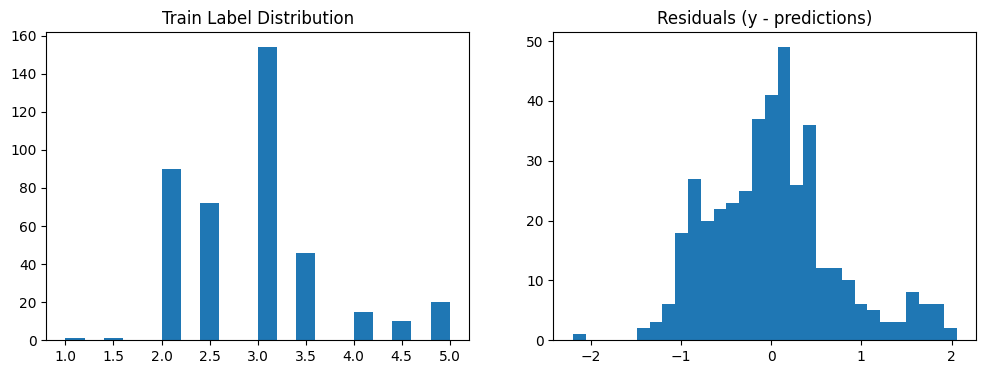

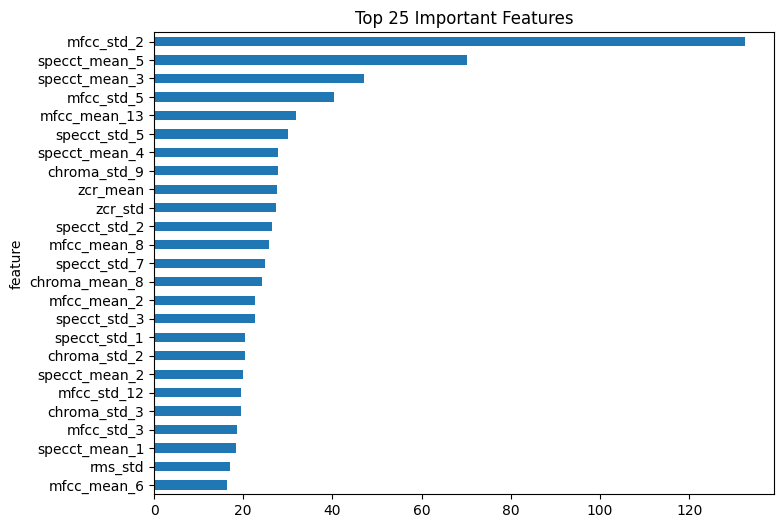

In [10]:
# 🔹 VISUALIZATIONS
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(y, bins=20)
plt.title("Train Label Distribution")

plt.subplot(1,2,2)
plt.hist(y - oof, bins=30)
plt.title("Residuals (y - predictions)")
plt.show()

fi = feature_importance_df.groupby("feature")["importance"].mean().sort_values(ascending=False).head(25)
plt.figure(figsize=(8,6))
fi.plot(kind="barh")
plt.title("Top 25 Important Features")
plt.gca().invert_yaxis()
plt.show()

In [11]:
# === Predict on Test Set ===

# Initialize predictions
preds = np.zeros(X_test.shape[0])

# Average predictions from all trained models
for model in models:
    preds += model.predict(X_test, num_iteration=model.best_iteration) / len(models)

# Clip predictions to [0, 5] range
preds = np.clip(preds, 0.0, 5.0)

# Create submission DataFrame
submission = pd.DataFrame({
    "filename": test["filename"],
    "label": preds
})

# Save submission file
submission.to_csv("submission.csv", index=False)
print("✅ submission.csv saved successfully!")
submission.head()


✅ submission.csv saved successfully!


,filename,label
0,audio_141,2.765303
1,audio_114,2.738832
2,audio_17,2.778951
3,audio_76,3.232357
4,audio_156,2.774454


In [37]:
from IPython.display import FileLink
FileLink('submission.csv')

/kaggle/working/submission.csv

In [12]:
train_oof = train.copy()
train_oof["oof_pred"] = oof
train_oof.to_csv("train_oof_predictions.csv", index=False)
print("✅ train_oof_predictions.csv saved.")

✅ train_oof_predictions.csv saved.


In [13]:
print(f"""
===================== REPORT =====================
Model: LightGBM Regressor (5-Fold CV)
Train RMSE (OOF): {train_rmse:.4f}

Features Used:
- MFCC mean/std (13×2)
- Chroma mean/std (12×2)
- Spectral contrast mean/std (7×2)
- Zero-crossing rate mean/std
- RMS mean/std

Next Improvements:
- Try CNN/LSTM on raw audio
- Add ASR-transcribed grammar-based features
- Apply data augmentation (noise/time stretch)
==================================================
""")


===================== REPORT =====================
Model: LightGBM Regressor (5-Fold CV)
Train RMSE (OOF): 0.6953

Features Used:
- MFCC mean/std (13×2)
- Chroma mean/std (12×2)
- Spectral contrast mean/std (7×2)
- Zero-crossing rate mean/std
- RMS mean/std

Next Improvements:
- Try CNN/LSTM on raw audio
- Add ASR-transcribed grammar-based features
- Apply data augmentation (noise/time stretch)



In [14]:
!pip install -q tensorflow tensorflow_hub tensorflow_io

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

print("\n🔹 Loading YAMNet pretrained model...")
yamnet_model = hub.load("https://tfhub.dev/google/yamnet/1")
print("✅ YAMNet model loaded successfully!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 6.1 MB/s eta 0:00:00:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.21.3 requires pyOpenSSL<=24.2.1,>=19.1.0, but you have pyopenssl 25.3.0 which is incompatible.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2025.1

2025-11-10 16:47:18.446165: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762793238.875747      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762793238.987286      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



🔹 Loading YAMNet pretrained model...


I0000 00:00:1762793277.754038      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762793277.754725      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


✅ YAMNet model loaded successfully!


In [15]:
def extract_yamnet_embeddings(path):
    try:
        file = tf.io.read_file(path)
        audio, sr = tf.audio.decode_wav(file, desired_channels=1)
        audio = tf.squeeze(audio, axis=-1)
        if sr != 16000:
            audio = tfio.audio.resample(audio, rate_in=sr, rate_out=16000)
        scores, embeddings, spectrogram = yamnet_model(audio)
        emb = tf.reduce_mean(embeddings, axis=0).numpy()
        return emb
    except Exception as e:
        print(f"⚠️ Error processing {path}: {e}")
        return np.zeros(1024)


In [16]:
def build_yamnet_df(df, verbose=True):
    rows = []
    for i, row in df.iterrows():
        emb = extract_yamnet_embeddings(row["path"])
        rows.append(emb)
        if verbose and (i + 1) % 25 == 0:
            print(f"Processed {i+1}/{len(df)} audio files...")
    arr = np.vstack(rows)
    feat_df = pd.DataFrame(arr, columns=[f"yamnet_{i}" for i in range(arr.shape[1])])
    feat_df["filename"] = df["filename"].values
    return feat_df


print("\n🔹 Extracting YAMNet embeddings for training set...")
yam_train = build_yamnet_df(train)
print("🔹 Extracting YAMNet embeddings for test set...")
yam_test = build_yamnet_df(test)



🔹 Extracting YAMNet embeddings for training set...
⚠️ Error processing /kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/train/audio_173.wav: {{function_node __wrapped__DecodeWav_device_/job:localhost/replica:0/task:0/device:CPU:0}} Header mismatch: Expected RIFF but found  [Op:DecodeWav] name: 
⚠️ Error processing /kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/train/audio_138.wav: {{function_node __wrapped__DecodeWav_device_/job:localhost/replica:0/task:0/device:CPU:0}} Header mismatch: Expected RIFF but found  [Op:DecodeWav] name: 


I0000 00:00:1762793282.912563    1790 cuda_dnn.cc:529] Loaded cuDNN version 90300


⚠️ Error processing /kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/train/audio_95.wav: {{function_node __wrapped__DecodeWav_device_/job:localhost/replica:0/task:0/device:CPU:0}} Header mismatch: Expected RIFF but found  [Op:DecodeWav] name: 
⚠️ Error processing /kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/train/audio_73.wav: {{function_node __wrapped__DecodeWav_device_/job:localhost/replica:0/task:0/device:CPU:0}} Header mismatch: Expected RIFF but found  [Op:DecodeWav] name: 
⚠️ Error processing /kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/train/audio_34.wav: in user code:

    File "/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/audio_ops.py", line 465, in f
        return core_ops.io_audio_resample(
    File "/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/__init__.py", line 88, in __getattr__
        return getattr(self._load(), attrb)
    File "/usr/local/lib/python3.11/dist-packages/tensorflow_

In [17]:
train_hybrid = train_feats.merge(yam_train, on="filename")
test_hybrid = test_feats.merge(yam_test, on="filename")

train_hybrid = train.merge(train_hybrid, on="filename")
test_hybrid = test.merge(test_hybrid, on="filename")

feature_cols = [c for c in train_hybrid.columns if c not in ["filename", "label", "path"]]
X_hybrid = train_hybrid[feature_cols].values
y_hybrid = train_hybrid["label"].values
X_test_hybrid = test_hybrid[feature_cols].values

In [18]:
imp = SimpleImputer(strategy="mean")
X_hybrid = imp.fit_transform(X_hybrid)
X_test_hybrid = imp.transform(X_test_hybrid)

scaler = StandardScaler()
X_hybrid = scaler.fit_transform(X_hybrid)
X_test_hybrid = scaler.transform(X_test_hybrid)

In [20]:
from lightgbm import early_stopping, log_evaluation

for fold, (tr_idx, val_idx) in enumerate(kf.split(X_hybrid, y_hybrid)):
    print(f"\n========== Hybrid Fold {fold+1} ==========")
    X_tr, X_val = X_hybrid[tr_idx], X_hybrid[val_idx]
    y_tr, y_val = y_hybrid[tr_idx], y_hybrid[val_idx]

    dtrain = lgb.Dataset(X_tr, label=y_tr)
    dval = lgb.Dataset(X_val, label=y_val)

    # ✅ Use callbacks for early stopping and logging
    model = lgb.train(
        params_hybrid,
        dtrain,
        num_boost_round=2000,
        valid_sets=[dtrain, dval],
        valid_names=["train", "valid"],
        callbacks=[
            early_stopping(stopping_rounds=75),
            log_evaluation(period=100)
        ]
    )

    val_preds = model.predict(X_val, num_iteration=model.best_iteration)
    oof_hybrid[val_idx] = val_preds
    hybrid_models.append(model)

    imp_df = pd.DataFrame({
        "feature": feature_cols,
        "importance": model.feature_importance(importance_type="gain")
    })
    imp_df["fold"] = fold + 1
    hybrid_fi_df = pd.concat([hybrid_fi_df, imp_df], axis=0)
    gc.collect()

hybrid_rmse = mean_squared_error(y_hybrid, oof_hybrid, squared=False)
print("\n✅ Final Hybrid OOF RMSE:", hybrid_rmse)



========== Hybrid Fold 1 ==========
Training until validation scores don't improve for 75 rounds
[100]	train's rmse: 0.432991	valid's rmse: 0.668824
Early stopping, best iteration is:
[120]	train's rmse: 0.395154	valid's rmse: 0.659622

========== Hybrid Fold 2 ==========
Training until validation scores don't improve for 75 rounds
[100]	train's rmse: 0.441395	valid's rmse: 0.659883
Early stopping, best iteration is:
[121]	train's rmse: 0.402813	valid's rmse: 0.657003

========== Hybrid Fold 3 ==========
Training until validation scores don't improve for 75 rounds
[100]	train's rmse: 0.418146	valid's rmse: 0.767984
[200]	train's rmse: 0.266883	valid's rmse: 0.755425
Early stopping, best iteration is:
[170]	train's rmse: 0.303064	valid's rmse: 0.754476

========== Hybrid Fold 4 ==========
Training until validation scores don't improve for 75 rounds
[100]	train's rmse: 0.425214	valid's rmse: 0.622335
[200]	train's rmse: 0.268992	valid's rmse: 0.621542
Early stopping, best iteration is:


In [21]:
preds_hybrid = np.zeros(X_test_hybrid.shape[0])
for model in hybrid_models:
    preds_hybrid += model.predict(X_test_hybrid, num_iteration=model.best_iteration) / len(hybrid_models)
preds_hybrid = np.clip(preds_hybrid, 0.0, 5.0)

submission_hybrid = pd.DataFrame({"filename": test["filename"], "label": preds_hybrid})
submission_hybrid.to_csv("submission_hybrid.csv", index=False)
print("✅ submission_hybrid.csv saved successfully!")
display(submission_hybrid.head())


✅ submission_hybrid.csv saved successfully!


,filename,label
0,audio_141,2.703950
1,audio_114,2.716625
2,audio_17,2.784429
3,audio_76,3.345023
4,audio_156,2.791269


In [22]:
# 🔹 Compare Classical vs Hybrid Models
# ==========================================================
print("\n================== COMPARISON ==================")
try:
    print(f"Baseline Model RMSE: {train_rmse:.4f}")
except:
    print("Baseline RMSE not found (may need rerun previous cell).")
print(f"Hybrid Model RMSE  : {hybrid_rmse:.4f}")
print("================================================\n")




================== COMPARISON ==================
Baseline Model RMSE: 0.6953
Hybrid Model RMSE  : 0.6933



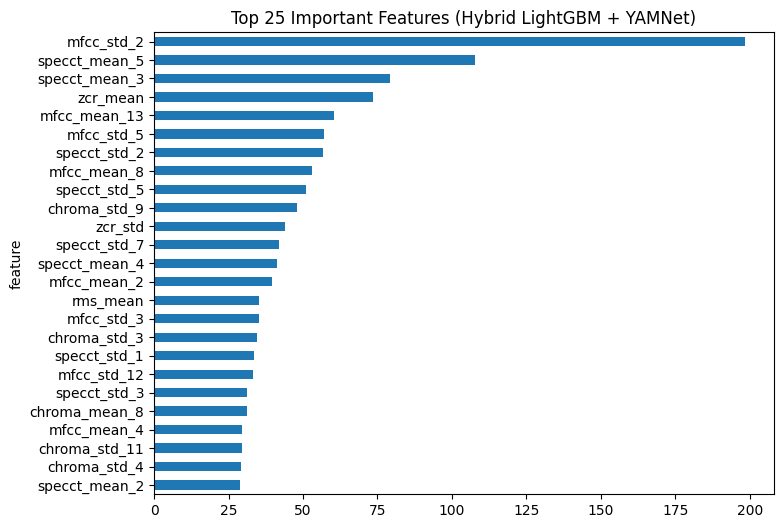

In [23]:
fi_hybrid = hybrid_fi_df.groupby("feature")["importance"].mean().sort_values(ascending=False).head(25)
plt.figure(figsize=(8,6))
fi_hybrid.plot(kind="barh")
plt.title("Top 25 Important Features (Hybrid LightGBM + YAMNet)")
plt.gca().invert_yaxis()
plt.show()

In [24]:
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# -----------------------
# Configuration
# -----------------------
SR = 16000
DURATION = 5.0            # seconds per crop
N_MELS = 64
HOP_LENGTH = 256
N_FFT = 1024
SAMPLES_PER_FILE = 6      # number of random crops per audio during training augmentation
VAL_CROPS = 10            # number of crops per validation/test file to average
BATCH_SIZE = 16
EPOCHS = 20               # reduce if no GPU
SEED = RANDOM_SEED

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [25]:
def load_audio_for_crop(path):
    # returns full audio at SR
    y, sr = librosa.load(path, sr=SR)
    y, _ = librosa.effects.trim(y)
    return y

def mel_crop_from_audio(y, start_sample, length_samples):
    clip = y[start_sample:start_sample + length_samples]
    if len(clip) < length_samples:
        clip = np.pad(clip, (0, length_samples - len(clip)), mode='constant')
    mel = librosa.feature.melspectrogram(y=clip, sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    # normalize per-spectrogram
    mel_db = (mel_db - mel_db.mean()) / (mel_db.std() + 1e-9)
    return mel_db.astype(np.float32)  # shape: (n_mels, time_frames)

In [26]:
# Build lists of audio paths and labels
# -----------------------
train_paths = train['path'].tolist()
train_labels = train['label'].values.astype(float)
test_paths = test['path'].tolist()

# Precompute full audio arrays for speed (optional, memory permitting)
print("Loading full audio arrays into memory (may use RAM).")
audio_cache = {}
for p in set(train_paths + test_paths):
    try:
        audio_cache[p] = load_audio_for_crop(p)
    except Exception as e:
        audio_cache[p] = np.zeros(int(SR * DURATION))
        print("Error loading", p, e)


Loading full audio arrays into memory (may use RAM).


In [27]:
# Generator (Keras Sequence) for training
# -----------------------
class MelCropSequence(keras.utils.Sequence):
    def __init__(self, paths, labels, batch_size=BATCH_SIZE, crops_per_file=SAMPLES_PER_FILE, shuffle=True):
        self.paths = paths
        self.labels = labels
        self.batch_size = batch_size
        self.crops_per_file = crops_per_file
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.paths))
        self.length_samples = int(DURATION * SR)
        self.on_epoch_end()

    def __len__(self):
        # number of batches per epoch
        return int(np.ceil(len(self.paths) * self.crops_per_file / self.batch_size))

    def __getitem__(self, idx):
        # build a batch of size batch_size using randomly selected file crops
        X_batch = []
        y_batch = []
        while len(X_batch) < self.batch_size:
            # pick a file randomly (with shuffle control)
            file_idx = random.choice(self.indexes) if self.shuffle else self.indexes[idx % len(self.indexes)]
            path = self.paths[file_idx]
            y_label = self.labels[file_idx]
            y_audio = audio_cache[path]
            max_start = max(1, len(y_audio) - self.length_samples)
            start = np.random.randint(0, max_start) if max_start > 1 else 0
            mel = mel_crop_from_audio(y_audio, start, self.length_samples)
            # resize time dimension to fixed length (pad/truncate)
            # Ensure time_frames consistent across samples by using same n_fft/hop -> frames vary; we'll resize using linear interpolation
            target_frames = int(np.ceil((self.length_samples) / HOP_LENGTH))
            if mel.shape[1] != target_frames:
                mel = tf.image.resize(mel[..., np.newaxis], (N_MELS, target_frames)).numpy()[...,0]
            # expand dims to add channel
            X_batch.append(mel[..., np.newaxis])
            y_batch.append(y_label)
        X_batch = np.stack(X_batch, axis=0)
        y_batch = np.array(y_batch, dtype=np.float32)
        return X_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [28]:
# Small validation split (file-level)
# -----------------------
train_paths_list = train['path'].tolist()
train_labels_list = train['label'].values

tr_paths, val_paths, tr_labels, val_labels = train_test_split(
    train_paths_list, train_labels_list, test_size=0.12, random_state=SEED, shuffle=True
)

train_seq = MelCropSequence(tr_paths, tr_labels, batch_size=BATCH_SIZE, crops_per_file=SAMPLES_PER_FILE, shuffle=True)
val_seq = MelCropSequence(val_paths, val_labels, batch_size=BATCH_SIZE, crops_per_file=1, shuffle=False)  # deterministic for val


In [29]:
# -----------------------
# Build CNN-LSTM model
# Input shape: (n_mels, time_frames, 1)
# -----------------------
# Determine target time frames from one example
example_y = audio_cache[train_paths_list[0]]
example_mel = mel_crop_from_audio(example_y, 0, int(DURATION * SR))
target_time_frames = int(np.ceil((int(DURATION * SR)) / HOP_LENGTH))
print("Target mel shape:", N_MELS, "x", target_time_frames)

input_shape = (N_MELS, target_time_frames, 1)
inputs = layers.Input(shape=input_shape)

# Conv blocks
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)

# Prepare for LSTM: collapse frequency axis -> time series of feature vectors
# Current shape: (batch, new_mels, new_time, channels)
shape = x.shape
# Permute to (batch, time, features)
x = layers.Permute((2,1,3))(x)  # time axis first
time_dim = int(x.shape[1])
feat_dim = int(x.shape[2] * x.shape[3])
x = layers.Reshape((time_dim, feat_dim))(x)

# LSTM
x = layers.Bidirectional(layers.LSTM(128, return_sequences=False))(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='linear')(x)

cnn_lstm_model = keras.Model(inputs, outputs)
cnn_lstm_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=[keras.metrics.RootMeanSquaredError()])
cnn_lstm_model.summary()

# -----------------------
# Callbacks
# -----------------------
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=6, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor='val_root_mean_squared_error', factor=0.5, patience=3, verbose=1)
]

# -----------------------
# Train the model
# -----------------------
history = cnn_lstm_model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=2
)


Target mel shape: 64 x 313


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 313, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 313, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 313, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 156, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 156, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 156, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 78, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, 78, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 78, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │     1,180,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,232,897 (4.70 MB)

 Trainable params: 1,232,705 (4.70 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/20
135/135 - 20s - 148ms/step - loss: 1.0938 - root_mean_squared_error: 1.0458 - val_loss: 13.8926 - val_root_mean_squared_error: 3.7273 - learning_rate: 1.0000e-04
Epoch 2/20
135/135 - 14s - 104ms/step - loss: 0.7025 - root_mean_squared_error: 0.8382 - val_loss: 8.1787 - val_root_mean_squared_error: 2.8598 - learning_rate: 1.0000e-04
Epoch 3/20
135/135 - 14s - 102ms/step - loss: 0.6293 - root_mean_squared_error: 0.7933 - val_loss: 1.1504 - val_root_mean_squared_error: 1.0726 - learning_rate: 1.0000e-04
Epoch 4/20
135/135 - 14s - 102ms/step - loss: 0.6297 - root_mean_squared_error: 0.7935 - val_loss: 0.2139 - val_root_mean_squared_error: 0.4624 - learning_rate: 1.0000e-04
Epoch 5/20
135/135 - 13s - 99ms/step - loss: 0.6344 - root_mean_squared_error: 0.7965 - val_loss: 0.3225 - val_root_mean_squared_error: 0.5679 - learning_rate: 1.0000e-04
Epoch 6/20
135/135 - 13s - 100ms/step - loss: 0.6000 - root_mean_squared_error: 0.7746 - val_loss: 0.2089 - val_root_mean_squared_error: 0.4

In [30]:
cnn_lstm_model.save("cnn_lstm_mel_model.h5")
print("Saved CNN-LSTM model.")


Saved CNN-LSTM model.


In [31]:
def predict_avg_on_file(model, path, n_crops=VAL_CROPS):
    y_audio = audio_cache[path]
    length_samples = int(DURATION * SR)
    preds = []
    for _ in range(n_crops):
        max_start = max(1, len(y_audio) - length_samples)
        start = np.random.randint(0, max_start) if max_start > 1 else 0
        mel = mel_crop_from_audio(y_audio, start, length_samples)
        # resize time dim:
        if mel.shape[1] != target_time_frames:
            mel = tf.image.resize(mel[..., np.newaxis], (N_MELS, target_time_frames)).numpy()[...,0]
        x = mel[..., np.newaxis][np.newaxis, ...]  # add batch
        p = model.predict(x, verbose=0)[0,0]
        preds.append(p)
    return float(np.mean(preds))

# Compute predictions for validation set and estimate RMSE
val_preds_list = []
val_true = []
for p, true_label in zip(val_paths, val_labels):
    pred = predict_avg_on_file(cnn_lstm_model, p, n_crops=VAL_CROPS)
    val_preds_list.append(pred)
    val_true.append(true_label)

val_rmse = mean_squared_error(np.array(val_true), np.array(val_preds_list), squared=False)
print(f"CNN-LSTM Validation RMSE: {val_rmse:.4f}")

CNN-LSTM Validation RMSE: 0.5842


In [32]:
test_cnn_preds = []
for tp in test_paths:
    pred = predict_avg_on_file(cnn_lstm_model, tp, n_crops=VAL_CROPS)
    test_cnn_preds.append(pred)
test_cnn_preds = np.clip(np.array(test_cnn_preds), 0.0, 5.0)

# Ensure hybrid preds exist (preds_hybrid from earlier cell)
if 'preds_hybrid' not in globals():
    # fallback: compute hybrid preds by averaging hybrid_models if available
    preds_hybrid = np.zeros(X_test_hybrid.shape[0])
    for m in hybrid_models:
        preds_hybrid += m.predict(X_test_hybrid, num_iteration=m.best_iteration) / len(hybrid_models)
    preds_hybrid = np.clip(preds_hybrid, 0.0, 5.0)

In [33]:
# Simple ensemble: weighted average (you can tune weights)
weight_hybrid = 0.6
weight_cnn = 0.4
final_preds = weight_hybrid * preds_hybrid + weight_cnn * test_cnn_preds
final_preds = np.clip(final_preds, 0.0, 5.0)

submission_ensemble = pd.DataFrame({"filename": test["filename"], "label": final_preds})
submission_ensemble.to_csv("submission_ensemble.csv", index=False)
print("✅ submission_ensemble.csv saved successfully!")
display(submission_ensemble.head())

✅ submission_ensemble.csv saved successfully!


,filename,label
0,audio_141,2.680170
1,audio_114,2.678579
2,audio_17,2.880254
3,audio_76,3.411733
4,audio_156,2.866159


In [34]:
# Summary outputs
# -----------------------
print(f"\n--- Model performance summary ---")
print(f"Hybrid LightGBM OOF RMSE: {hybrid_rmse:.4f}" if 'hybrid_rmse' in globals() else "Hybrid RMSE: N/A")
print(f"CNN-LSTM val RMSE       : {val_rmse:.4f}")
print(f"Final ensemble saved to submission_ensemble.csv (weights H:{weight_hybrid}, C:{weight_cnn})")


--- Model performance summary ---
Hybrid LightGBM OOF RMSE: 0.6933
CNN-LSTM val RMSE       : 0.5842
Final ensemble saved to submission_ensemble.csv (weights H:0.6, C:0.4)


In [35]:
from IPython.display import FileLink
FileLink('submission_ensemble.csv')


/kaggle/working/submission_ensemble.csv

In [36]:
from IPython.display import FileLink
FileLink('submission_hybrid.csv')

/kaggle/working/submission_hybrid.csv